# Generate MNIST dataset on a black canvas

## Generate the artificial dataset

### Imports

In [1]:
import os
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

2021-11-22 21:21:55.796886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-22 21:21:55.796910: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.5.0


### Parameters

In [2]:
NEW_IMG_SIZE = 200
BATCH_SIZE = 32
MAX_DATA = 200
N_BOXES = 4

### Visualization Utilities

These functions are used to draw bounding boxes around the digits.

In [3]:
use_normalized_coordinates = True
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
  """Draws bounding boxes on image (numpy array).
  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness,
                               display_str_list)
  return np.array(rgbimg)
  

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.
                           
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2],  thickness)
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  NEW_IMG_SIZE, NEW_IMG_SIZE = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * NEW_IMG_SIZE, xmax * NEW_IMG_SIZE,
                                  ymin * NEW_IMG_SIZE, ymax * NEW_IMG_SIZE)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  


In [4]:

'''
Transforms each image in dataset by pasting it on a NEW_IMG_SIZExNEW_IMG_SIZE canvas at random locations.
'''
def draw_on_canvas(images_numpy):
    imgs = []
    bboxes = []
    for image_numpy in images_numpy:
        image = tf.convert_to_tensor(image_numpy)
        xmin = tf.random.uniform((), 0 , NEW_IMG_SIZE - 28 - 3, dtype=tf.int32)
        ymin = tf.random.uniform((), 0 , NEW_IMG_SIZE - 28 - 3, dtype=tf.int32)
        image = tf.reshape(image, (28,28,1,))
        image = tf.image.pad_to_bounding_box(image, ymin, xmin, NEW_IMG_SIZE, NEW_IMG_SIZE)
    
        image = tf.cast(image, tf.float32)/255.0
        
        #image += tf.random.uniform((NEW_IMG_SIZE, NEW_IMG_SIZE, 1), minval=0, maxval=0.01)
    
    
        xmin = tf.cast(xmin, tf.float32)
        ymin = tf.cast(ymin, tf.float32)
   
        xmax = (xmin + 28) / NEW_IMG_SIZE
        ymax = (ymin + 28) / NEW_IMG_SIZE
        xmin = xmin / NEW_IMG_SIZE
        ymin = ymin / NEW_IMG_SIZE

        imgs.append(image)
        box = np.array([xmin, ymin, xmax, ymax])
        bboxes.append(box)


    return (sum(imgs)).numpy(), np.array(bboxes)


In [5]:
def get_train_test(max_data=100):
    ds_train = tfds.load(name="mnist", split="train")
    ds_numpy = tfds.as_numpy(ds_train)
    images = []
    train_labels = []
    for i, data in enumerate(ds_numpy):
        if i > max_data:
            break
        images.append(data["image"])
        train_labels.append(data["label"])
    
    return np.array(images), np.array(train_labels)
    
def generate_bboxes(ds_numpy, labels_np, max_data=100):
    images = []
    bboxes = []
    labels = []

    for i in range(max_data):
        idx = np.random.choice(MAX_DATA, N_BOXES)
        imgs = ds_numpy[idx]
        img, boxes = draw_on_canvas(imgs)

        images.append(img)
        bboxes.append(boxes)
        labels.append(labels_np[idx])
        
        
    return np.array(images), np.array(bboxes), np.array(labels)

In [6]:
images, labels = get_train_test(max_data=MAX_DATA)
images.shape, labels.shape

2021-11-22 21:21:58.542715: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-22 21:21:58.567315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 21:21:58.567706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-11-22 21:21:58.567808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-22 21:21:58.567871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic li

((201, 28, 28, 1), (201,))

In [7]:
images, bboxes, labels = generate_bboxes(images, labels, max_data=MAX_DATA)

### Visualize Data

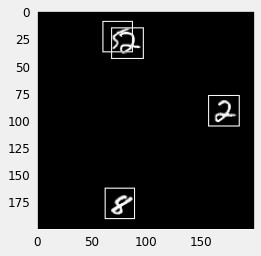

In [8]:
img = draw_bounding_boxes_on_image_array(255*images[0].reshape(NEW_IMG_SIZE, NEW_IMG_SIZE), boxes=bboxes[0], color='red')
plt.imshow(img)
plt.imsave("example.png", img)

## Writing a custom dataset

Let's output a dataset.

In [9]:
#images_wcanvac, train_bboxes
import cv2
import pandas as pd
df = pd.DataFrame()

img_names = []
bboxes_list = []
label_list = []
for i, (img, bbox, label) in enumerate(zip(images, bboxes, labels)):
    
    #img = np.expand_dims(img, axis=1)
    print(img.shape)
    # im = Image.fromarray()
    img = (img * 255).astype('uint8')
    cv2.imwrite(f"images/{i}.png", img)
    
    img_names.append(f"images/{i}.png")
    bboxes_list.append(bbox)
    label_list.append(label)
    #im = Image.fromarray(np.uint8(img*255), 'L')

    print(i)
    
df["image_path"] = img_names
df["bboxes"] = bboxes_list
df["label"] = label_list
    

(200, 200, 1)
0
(200, 200, 1)
1
(200, 200, 1)
2
(200, 200, 1)
3
(200, 200, 1)
4
(200, 200, 1)
5
(200, 200, 1)
6
(200, 200, 1)
7
(200, 200, 1)
8
(200, 200, 1)
9
(200, 200, 1)
10
(200, 200, 1)
11
(200, 200, 1)
12
(200, 200, 1)
13
(200, 200, 1)
14
(200, 200, 1)
15
(200, 200, 1)
16
(200, 200, 1)
17
(200, 200, 1)
18
(200, 200, 1)
19
(200, 200, 1)
20
(200, 200, 1)
21
(200, 200, 1)
22
(200, 200, 1)
23
(200, 200, 1)
24
(200, 200, 1)
25
(200, 200, 1)
26
(200, 200, 1)
27
(200, 200, 1)
28
(200, 200, 1)
29
(200, 200, 1)
30
(200, 200, 1)
31
(200, 200, 1)
32
(200, 200, 1)
33
(200, 200, 1)
34
(200, 200, 1)
35
(200, 200, 1)
36
(200, 200, 1)
37
(200, 200, 1)
38
(200, 200, 1)
39
(200, 200, 1)
40
(200, 200, 1)
41
(200, 200, 1)
42
(200, 200, 1)
43
(200, 200, 1)
44
(200, 200, 1)
45
(200, 200, 1)
46
(200, 200, 1)
47
(200, 200, 1)
48
(200, 200, 1)
49
(200, 200, 1)
50
(200, 200, 1)
51
(200, 200, 1)
52
(200, 200, 1)
53
(200, 200, 1)
54
(200, 200, 1)
55
(200, 200, 1)
56
(200, 200, 1)
57
(200, 200, 1)
58
(200, 2

In [10]:
df

,image_path,bboxes,label
0,images/0.png,"[[0.345, 0.075, 0.485, 0.215], [0.785, 0.39, 0...","[2, 2, 8, 5]"
1,images/1.png,"[[0.27, 0.28, 0.41, 0.42], [0.225, 0.06, 0.365...","[2, 4, 7, 7]"
2,images/2.png,"[[0.2, 0.16, 0.34, 0.3], [0.58, 0.19, 0.72, 0....","[2, 8, 3, 8]"
3,images/3.png,"[[0.535, 0.515, 0.675, 0.655], [0.22, 0.675, 0...","[4, 6, 1, 5]"
4,images/4.png,"[[0.785, 0.455, 0.925, 0.595], [0.175, 0.725, ...","[8, 2, 4, 4]"
...,...,...,...
195,images/195.png,"[[0.11, 0.505, 0.25, 0.645], [0.44, 0.21, 0.58...","[4, 1, 8, 8]"
196,images/196.png,"[[0.765, 0.575, 0.905, 0.715], [0.145, 0.53, 0...","[4, 1, 4, 3]"
197,images/197.png,"[[0.185, 0.22, 0.325, 0.36], [0.72, 0.21, 0.86...","[9, 6, 6, 9]"
198,images/198.png,"[[0.825, 0.095, 0.965, 0.235], [0.645, 0.255, ...","[9, 1, 4, 8]"


In [12]:
df.to_pickle("annotations.pkl")
df.to_csv("annotations.csv")